# POLI 175 - Lecture 11

## Classification

## Announcement

- Problem set due on 02/08 (this Wednesday)!

# Classification

## Classification

- Linear regression is great! But it assumes we want to predict a continuous target variable.

- But there are situations when our response variables is qualitative.

**Examples:**

- Whether a country default its debt obligations?

- Whether a person voted Republican, Democrat, Independent, voted for a different party, or did not turnout to vote?

- What determines the number of FOI requests that a given public office receives every day?

- Is a country expected to meet, exceed, or not meet the Paris Treaty Nationally Determined Contributions?

All these questions are qualitative in nature.

## Class Example

- In 1988, the Chilean Dictator Augusto Pinochet conducted a referendum to whether he should step out.

- The FLACSO in Chile conducted a surver on 2700 respondents.

- We are going to build a model to predict their voting intentions.

## Data

| **Variable** | **Meaning** |
|:---:|---|
| region | A factor with levels:<br>- `C`, Central; <br>- `M`, Metropolitan Santiago area; <br>- `N`, North; <br>- `S`, South; <br>- `SA`, city of Santiago. |
| population | The population size of respondent's community. |
| sex | A factor with levels: <br>- `F`, female; <br>- `M`, male. |
| age | The respondent's age in years. |
| education | A factor with levels: <br>- `P`, Primary; <br>- `S`, Secondary; <br>- `PS`, Post-secondary. |
| income | The respondent's monthly income, in Pesos. |
| statusquo | A scale of support for the status-quo. |
| vote | A factor with levels: <br>- `A`, will abstain; <br>- `N`, will vote no (against Pinochet);<br>- `U`, is undecided; <br>- `Y`, will vote yes (for Pinochet). |

In [27]:
## Loading the relevant packages
import pandas as pd
import numpy as np

## Loading Libraries and Modules
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Loading scikit learn relevant packages (more on that later)
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics

In [2]:
## Loading the data
chile = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/chilesurvey.csv')
chile.head()
chile_clean = chile.dropna()
chile_clean = chile_clean[chile_clean['vote'].isin(['Y', 'N'])]
chile_clean['vote'] = np.where(chile_clean['vote'] == 'Y', 1, 0)
chile_clean['logincome'] = np.log(chile_clean['income'])
chile_clean['logpop'] = np.log(chile_clean['population'])
chile_clean.head()

,region,population,sex,age,education,income,statusquo,vote,logincome,logpop
0,N,175000,M,65.0,P,35000.0,1.00820,1,10.463103,12.072541
1,N,175000,M,29.0,PS,7500.0,-1.29617,0,8.922658,12.072541
2,N,175000,F,38.0,P,15000.0,1.23072,1,9.615805,12.072541
3,N,175000,F,49.0,P,35000.0,-1.03163,0,10.463103,12.072541
4,N,175000,F,23.0,S,35000.0,-1.10496,0,10.463103,12.072541


## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**My suggestion:**

- If you want to **measure a treatment effect**, or any other fitting where **explanation trumps prediction**, go with the linear regression.
    + Easy to explain to a lay audience.
    + Good polynomial expansion around the ATE.
    + Needs a careful design (in Causal Inference, the design is more important than the statistical method!).
    + Interaction terms are just partial derivatives of the fitted equation.

## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**My suggestion:**

- If you want to **predict outcomes**, go with a classification model appropriate for your target variable unit.
    + You are not going to do `weird` prediction.
    + You have a marginal efficiency gain (in terms of Standard Errors).
    + If you have an ordered target variable, your model does look like more meaningful.
    + Need to be careful about interaction terms (has to do with taking derivatives of link function in Generalized Linear Models).

## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**My suggestion:**

- Be **careful when you have discrete nominal variation in your target variable**:
    + Binary outcome: Linear Regression and Linear Discriminant Analysis are the same.
    + Three or more categories, like the `vote` in the Chilean dataset messes up badly with things.

## Book's Example

Chance of Default on Credit Card Debt by Account Balance:

![linear x logistic regression IRLR book](../img/linvslogit.png)

## Logistic Regression

Logistic Regression belongs to a class of models called [Generalized Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model) (or GLM for short).

- A GLM, in a nutshell (and in a proudly lazy definition) is an expansion of Linear Model that assumes:
    + A Linear Relationship in part of the model
    + But then applies a non-linear transformation to the response variable.

- The non-linear transformation is called `link function`. Many link functions around (check [here](https://en.wikipedia.org/wiki/Generalized_linear_model) for various link functions).

- The link function is going to determine which types of models we run.

- When the outcome variable is binary, we may use the `Logistic` or `Probit` links.

## Logistic Regression

In a regression, we are investigating something along the lines of:

$$ \mathbb{E}[Y | X] \ = \ \beta_0 + \beta_1 X $$

But when the outcome is binary we would like to get:

$$ \mathbb{E}[Y | X] \ = \ \mathbb{P}(Y = 1 | X) $$

And the Logistic link is nothing but:

$$ \mathbb{P}(Y = 1 | X) \ = \ \dfrac{e^{(\beta_0 + \beta_1X)}}{1 + e^{(\beta_0 + \beta_1X)}} $$

## Logistic Regression

With a bit of manipulation, we get to something called odds ratio:

$$ \dfrac{\mathbb{P}(Y = 1 | X)}{\mathbb{P}(Y = 0 | X)} \ = \ \dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)} \ = \ e^{(\beta_0 + \beta_1X)} $$

And logging the thing gets rid of the Euler constant:

$$ \log \left( \dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)}\right) \ = \ \beta_0 + \beta_1X $$

And this is the Logit Link.

## Logistic Regression

Little detour to talk about odd ratios:

- Note the odd ratio: $\dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)}$

- It is a ratio between the chance of $Y = 1$ divided by the chance of $Y = 0$.

- Since probabilities are between zero and one, the ratio is always between $(0, \infty)$.

Example:

- If based on characteristics, two in every ten people vote for Pinochet, $\mathbb{P}(Y = 1 | X = \text{some characs.}) = 0.2$ and the odds ratio is $1/4$.

- If based on other set of characteristics, nine out of ten people vote for Pinochet, $\mathbb{P}(Y = 1 | X = \text{some other characs.}) = 0.9$ and the odds ratio is $9$.

- One is like the number that does not change the ratios.


## Logistic Regression

Little other detour to talk about the coefficients:

- In linear regression, changes in one unit of $x_i$ changes your target variable in $\beta_i$ units, on average.

- In logistic regression, changes in one unit of $x_i$ changes **the log odds** your target variable in $\beta_i$ units, on average.

- Multiplies the odds by $e^{\beta_i}$! This is **not** a straight line!

- Easy proxy (does not work for interaction terms): 
    + When $\beta_1$ is **positive**, it **increases** the $\mathbb{P}(Y = 1 | X)$
    + When $\beta_1$ is **negative**, it **decreases** the $\mathbb{P}(Y = 1 | X)$
    
- Try to compute the partial derivatives on $X$ and you will see the complications!

## Logistic Regression

Technical:

1. The estimation is through [maximizing the likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).
    + This is outside the scope of the course, but an interesting topic to learn in an advanced course.


2. The hypothesis test for the coefficient's significance in here is a Z-test (based on the Normal distribution).
    + Null Hypothesis: $H_0: \ \beta_i = 0$ or alternatively $H_0: \ e^{\beta_i} = 1$.


3. Making predictions:
    + Just insert the predicted $\hat{\beta}$s on the equation.
    
$$ \hat{p}(X) \ = \ \dfrac{e^{\hat{\beta}_0 + \hat{\beta}_1 X}}{1 + e^{\hat{\beta}_0 + \hat{\beta}_1 X}} $$

## Logistic Regression

- First, let's fit a Linear Regression:

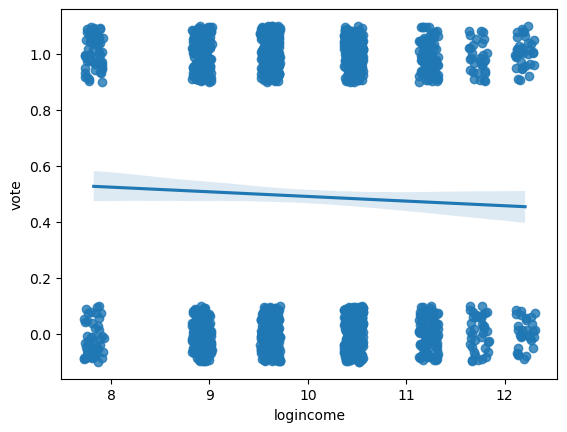

In [3]:
sns.regplot(x = 'logincome', y = 'vote', x_jitter = 0.1, y_jitter = 0.1, data = chile_clean)
plt.show()

## Logistic Regression

- First, let's fit a Linear Regression:

In [4]:
# Linear Model
modlin = ols('vote ~ logincome', data = chile_clean).fit()
modlin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vote   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.994
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.158
Time:                        15:25:57   Log-Likelihood:                -1234.7
No. Observations:                1703   AIC:                             2473.
Df Residuals:                    1701   BIC:                             2484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6568      0.118      5.560      0.000       0.425       0.889
logincome     -0.0166      0.012     -1.412      0.158      -0.040       0.006
==============================================================================
Omnibus:                     6175.448   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.505
Skew:                           0.037   Prob(JB):                     4.52e-62
Kurtosis:                       1.006   Cond. No.                         99.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Logistic Regression

- Let's fit a Logistic Regression:

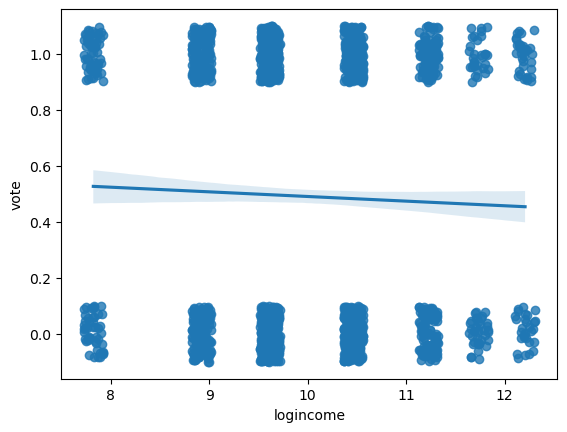

In [5]:
## Seaborn plot
sns.regplot(x = 'logincome', y = 'vote', 
            x_jitter = 0.1, y_jitter = 0.1, 
            data = chile_clean, logistic = True)
plt.show()

## Logistic Regression

- Let's fit a Logistic Regression:

In [6]:
# Logistic Regression
modlogit = logit('vote ~ logincome', data = chile_clean).fit()
modlogit.summary()

Optimization terminated successfully.
         Current function value: 0.692396
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   vote   No. Observations:                 1703
Model:                          Logit   Df Residuals:                     1701
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:               0.0008452
Time:                        15:26:04   Log-Likelihood:                -1179.2
converged:                       True   LL-Null:                       -1180.1
Covariance Type:            nonrobust   LLR p-value:                    0.1578
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6282      0.473      1.327      0.185      -0.300       1.556
logincome     -0.0665      0.047     -1.411      0.158      -0.159       0.026
==============================================================================
"""

## Logistic Regression

- Let's fit a Logistic Regression:

In [7]:
# Logistic Regression
modlogit2 = logit('vote ~ logincome + logpop + region + age + education', data = chile_clean).fit()
modlogit2.summary()

Optimization terminated successfully.
         Current function value: 0.647295
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   vote   No. Observations:                 1703
Model:                          Logit   Df Residuals:                     1693
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                 0.06593
Time:                        15:26:04   Log-Likelihood:                -1102.3
converged:                       True   LL-Null:                       -1180.1
Covariance Type:            nonrobust   LLR p-value:                 6.060e-29
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4750      0.798      0.595      0.552      -1.089       2.039
region[T.M]         0.8302      0.321      2.586      0.010       0.201       1.459
region[T.N]         0.6427      0.178      3.620      0.000       0.295       0.991
region[T.S]         0.4885      0.146      3.349      0.001       0.203       0.774
region[T.SA]        0.3007      0.160      1.879      0.060      -0.013       0.614
education[T.PS]    -1.0723      0.172     -6.249      0.000      -1.409      -0.736
education[T.S]     -0.6103      0.128     -4.753      0.000      -0.862      -0.359
logincome           0.2482      0.060      4.113      0.000       0.130       0.366
logpop             -0.2964      0.059     -5.057      0.000      -0.411      -0.182
age                 0.0137      0.004      3.743      0.000       0.007       0.021
===================================================================================
"""

## Logistic Regression

- Let's look at the parameters:

In [8]:
## Parameters
np.exp(modlogit2.params)

Intercept          1.607991
region[T.M]        2.293693
region[T.N]        1.901602
region[T.S]        1.629846
region[T.SA]       1.350806
education[T.PS]    0.342228
education[T.S]     0.543187
logincome          1.281721
logpop             0.743506
age                1.013824
dtype: float64

## Logistic Regression

- Let's look at the parameters:

In [9]:
## Parameters
np.exp(modlogit2.params)-1

Intercept          0.607991
region[T.M]        1.293693
region[T.N]        0.901602
region[T.S]        0.629846
region[T.SA]       0.350806
education[T.PS]   -0.657772
education[T.S]    -0.456813
logincome          0.281721
logpop            -0.256494
age                0.013824
dtype: float64

## Logistic Regression

- Now with Scikit Learn:

In [26]:
# Target variable
y = chile_clean['vote']

# Predictors
X = chile_clean[['logincome', 'logpop', 'age']]

# Loading the model
logreg =  LogisticRegression() 

# Fitting the model
logreg.fit(X, y)

# Getting parameters
print(logreg.intercept_, logreg.coef_)

# Note the absence of categorical predictors.
# Next class we will see how to create dummies for them.

[[ 0.0453639  -0.3392518   0.02031414]] [2.63089802]


# Questions?

# See you next class
